In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
from mord import LogisticAT
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from yellowbrick.model_selection import LearningCurve
from kappa_loss import KappaLossNN, KappaLossLGBM
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
from skll.metrics import kappa
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize': (15.7, 8.27)})

In [2]:
# Ensure non-sklearn models have proper label
# Without this, automatic stratification doens't occur
from sklearn.base import is_classifier
LogisticAT._estimator_type = "classifier" # type: ignore
assert is_classifier(LogisticAT) 
assert is_classifier(KappaLossNN)
assert is_classifier(XGBClassifier)
assert is_classifier(KappaLossLGBM)

In [3]:
df = pd.read_csv("./data/preprocessed_data.csv", index_col=0)

TARGET = "NSP"
FEATURES = df.columns.drop(TARGET)

# Reserve a "final final" test set
X = df[FEATURES].values
y = LabelEncoder().fit(df[TARGET]).transform(df[TARGET].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [4]:
# error metrics for each class of fetal state
f1Scorer1 = make_scorer(lambda x, y: f1_score(x, y, average=None)[0])
f1Scorer2 = make_scorer(lambda x, y: f1_score(x, y, average=None)[1])
f1Scorer3 = make_scorer(lambda x, y: f1_score(x, y, average=None)[2])
precScorer1 = make_scorer(lambda x, y: precision_score(x, y, average=None)[0])
precScorer2 = make_scorer(lambda x, y: precision_score(x, y, average=None)[1])
precScorer3 = make_scorer(lambda x, y: precision_score(x, y, average=None)[2])
recallScorer1 = make_scorer(lambda x, y: recall_score(x, y, average=None)[0])
recallScorer2 = make_scorer(lambda x, y: recall_score(x, y, average=None)[1])
recallScorer3 = make_scorer(lambda x, y: recall_score(x, y, average=None)[2])

# Penalties for different types of class confusion
weights = np.array([
# Predicted   N    S    P     # True
            [0.0, 0.5, 0.6],  # N
            [1.0, 0.0, 0.3],  # S
            [2.0, 0.6, 0.0]   # P
])
def weightedKappa(x, y): return kappa(x, y, weights=weights)

kappaScorer = make_scorer(weightedKappa)

complete_scorer = {
    'f1-N': f1Scorer1, 'f1-S': f1Scorer2, 'f1-P': f1Scorer3,
    'prec-N': precScorer1, 'prec-S': precScorer2, 'prec-P': precScorer3,
    'recall-N': recallScorer1, 'recall-S': recallScorer2, 'recall-P': recallScorer3,
    'weighted-kappa': kappaScorer
}

In [5]:
# class weight between None and "Balanced"
class_weight_intermediate = {0: 1, 1: 2, 2: 3}
class_weight_high = {0: 1, 1: 10, 2: 20}
model_params = {
    'logisticOVR': {
        'model__C': [1, 5, 10],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'kappaNN': {
        'model__alpha': [0, .03, .02, .01],
        'model__hidden_layer_shapes': [[], [5], [5,5]]
    },
    'ordinal': {'model__alpha': [0, 0.5, 1, 2]},
    'RF': {
        'model__n_estimators': [1, 10, 20],
        'model__max_features': ['sqrt', None],
        'model__max_depth': [None, 5, 10, 20],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'rbfSVM': {
        'model__C': [1, 5, 10],
        'model__gamma': [0.001, 0.0001],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'KNN': {'model__n_neighbors': [3, 5, 7, 9, 11, 13],
            'model__weights': ['uniform', 'distance']},
    'KappaLGBM': {
        # 'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high],
        # 'model__max_depth': [None, 5, 10, 20],
    },
    'LightGBM': {
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high],
        'model__max_depth': [None, 5, 10, 20],
    }
}

pipe_params = {
    # 'PCA': [None, PCA(), PCA(15), PCA(10), PCA(5)],
    # 'smote': [None, SMOTE()]
    'PCA': [None],
    'smote': [None]
}

In [6]:
cvs = {
    "fast": {'inner': 2, 'outer': 2},
    "slow": {'inner': 3, 'outer': 5}
}
CV = cvs['fast']
def make_pipeline(model):
    return Pipeline(steps=[
               ('smote', SMOTE()),
               ('scaler', StandardScaler()),
               ('PCA', PCA()),
               ('model', model)
           ])

def make_inner_kfold(pipeline, preprocessing_grid, model_grid):
    full_grid = {}
    full_grid.update(preprocessing_grid)
    full_grid.update(model_grid)
    return GridSearchCV(pipeline, param_grid=full_grid, cv=CV['inner'], n_jobs=-1, 
                        scoring=kappaScorer)


models = {
    # "logisticOVR": LogisticRegression(
    #     max_iter=5000, multi_class='ovr'
    # ),
    # "logisticMN": LogisticRegression(
    #     max_iter=5000, multi_class='multinomial'
    # ),
    # "LightGBM": LGBMClassifier,
    "KappaLGBM": KappaLossLGBM(num_classes=3, weight_matrix=list(weights)),
    # "kappaNN": KappaLossNN(num_classes=3, weight_matrix=weights, max_iter=5000)
    # "ordinal": LogisticAT(),
    # "RF": RandomForestClassifier(),
    # "rbfSVM": svm.SVC(kernel="rbf"),
    # "KNN": KNeighborsClassifier(),
}

piped_models = {
    key: make_pipeline(model) 
    for key, model in models.items()
}

piped_folded_models = {
    key: make_inner_kfold(pipe, pipe_params, model_params[key])
    for key, pipe in piped_models.items()
}

In [7]:
scores = {}
for key, model in piped_folded_models.items():
    # Instantiate the classification model and visualizer
    scores[key] = cross_validate(
        model, X=X_train, y=y_train, 
        cv=CV['outer'], scoring=complete_scorer, n_jobs=-1, verbose=10
        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] 

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabil

[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabil

[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabil

[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabil

[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]
[LightGBM] [Warning] 0. is set=, 0.= will be ignored. Current value: 0.=
[LightGBM] [Warning] Unknown parameter: 0.3],[2.
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 0.6
[LightGBM] [Warning] Unknown parameter: weight_matrix
[LightGBM] [Warning] Unknown parameter: 0.
[LightGBM] [Warning] Unknown parameter: 0.6],[1.
[LightGBM] [Warning] Unknown parameter: ]


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


[CV] END  f1-N: (test=0.931) f1-P: (test=0.823) f1-S: (test=0.634) prec-N: (test=0.956) prec-P: (test=0.773) prec-S: (test=0.579) recall-N: (test=0.907) recall-P: (test=0.879) recall-S: (test=0.700) weighted-kappa: (test=0.765) total time= 8.9min
[CV] END  f1-N: (test=0.924) f1-P: (test=0.588) f1-S: (test=0.706) prec-N: (test=0.968) prec-P: (test=0.481) prec-S: (test=0.661) recall-N: (test=0.884) recall-P: (test=0.758) recall-S: (test=0.757) weighted-kappa: (test=0.738) total time= 8.9min


/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  9.0min finished


In [8]:
def ff(a):
    return np.mean(a) - np.std(a)
pd.DataFrame(scores).applymap(ff).T

,fit_time,score_time,test_f1-N,test_f1-P,test_f1-S,test_prec-N,test_prec-P,test_prec-S,test_recall-N,test_recall-P,test_recall-S,test_weighted-kappa
KappaLGBM,535.05778,0.073943,0.924115,0.588235,0.633745,0.955857,0.480769,0.578947,0.883871,0.757576,0.7,0.737521


<AxesSubplot:xlabel='model', ylabel='test_weighted-kappa'>

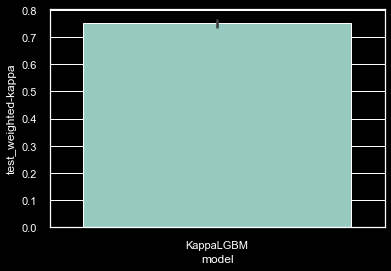

In [9]:
x = pd.concat([ pd.DataFrame(scores[key]).assign(model=key) for key in scores.keys()])
sns.barplot(x="model", y="test_weighted-kappa", data=x)

In [ ]:
def f(a):
    return np.mean(a) - np.std(a)
pd.DataFrame(scores).applymap(f).T

,fit_time,score_time,test_f1-N,test_f1-S,test_f1-P,test_prec-N,test_prec-S,test_prec-P,test_recall-N,test_recall-S,test_recall-P,test_weighted-kappa
logisticOVR,27.997537,0.010828,0.919192,0.617065,0.726648,0.960170,0.532585,0.637799,0.865669,0.694770,0.796522,0.752066
logisticMN,28.210552,0.009349,0.915181,0.580778,0.725801,0.960701,0.485635,0.671240,0.858159,0.680389,0.780240,0.743147
kappaPerceptron,43.817992,0.167996,0.873060,0.605103,0.657306,0.982798,0.475207,0.526437,0.784990,0.817518,0.818204,0.703126
ordinal,7.130449,0.009418,0.877241,0.448015,0.725096,0.930544,0.362325,0.669615,0.789825,0.522734,0.684625,0.658802
RF,104.211742,0.013534,0.954259,0.728370,0.859161,0.953877,0.731643,0.834584,0.951764,0.714059,0.861770,0.820309
rbfSVM,37.821143,0.045160,0.917812,0.624279,0.717475,0.961569,0.534995,0.645497,0.851979,0.715718,0.779592,0.752543
KNN,6.400133,0.025748,0.932114,0.676614,0.782818,0.957132,0.598245,0.729401,0.899209,0.737486,0.814731,0.774361
XGBoost,104.819473,0.017472,0.962572,0.772320,0.881912,0.960996,0.777340,0.859037,0.961329,0.761108,0.852453,0.846552
